In [3]:
import pandas as pd
import numpy as np
import os
import glob
import nibabel as nb
import scipy.stats
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array
#from brainstat.stats.SLM import SLM
#from brainstat.stats.terms import FixedEffect
#from brainstat.datasets.base import combine_surfaces
import seaborn as sns


# Path to MICAPIPEsurf = mask_5k !
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_5k = np.concatenate((mask_lh, mask_rh), axis=0)

# Labels and boolean mask
mask_surf = mask_5k != 0

# Smooth intencities
def smooth_surf(surf_l, surf_r, points, Mask, Kernel='uniform', Niter=3, Relax=0.35):
    '''
    This function smooth an array (left and right) on a given surface
    Parameters
    ----------
    surf_l : np.array left surface 
    surf_r : np.array right surface
    points : np.array surface data
    Kernel : {'uniform', 'gaussian', 'inverse_distance'}
    Niter  : int, optional Number of smooth iterations
    Relax  : relax : float, optional relaxation factor
    Mask   : str or 1D ndarray, optional
    Returns
    -------
    sdata : smoothed numpy array
    
    '''
    Ndim = Mask.shape[0] 
    n2dim = int(Ndim/2)
    Mask_l=Mask[0:n2dim]
    Mask_r=Mask[n2dim:Ndim]
    sdata = np.concatenate((smooth_array(surf_l, points[0:n2dim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_l), 
                          smooth_array(surf_r, points[n2dim:Ndim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_r)), axis=0)
    return(sdata)

# Smooth each intencity
def smooth_intensities(int_profile):
    smoothed_i = np.copy(int_profile)
   
    # smooth each intensity
    for i in range(int_profile.shape[0]):
        smoothed_i[i,:] = smooth_surf(inf_lh, inf_rh, int_profile[i,:], mask_surf,Niter=5, Relax=0.5, Kernel='uniform')
   
    return(smoothed_i)


# Function to build the MPC from an intencity profile
def build_mpc(data, mask):
    # If no parcellation is provided, MPC will be computed vertexwise
    I = data

    # Calculate mean across columns, excluding mask and any excluded labels input
    I_M = np.nanmean(np.float32(np.where(mask, I, np.nan)), axis=1)

    # Get residuals of all columns (controlling for mean)
    I_resid = np.zeros(I.shape)
    for c in range(I.shape[1]):
        y = I[:,c]
        x = I_M
        slope, intercept, _, _, _ = scipy.stats.linregress(x,y)
        y_pred = intercept + slope*x
        I_resid[:,c] = y - y_pred

    # Calculate correlation coefficient of the intesities with residuals
    R = np.corrcoef(I_resid, rowvar=False)

    # Log transform
    MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
    MPC[np.isnan(MPC)] = 0
    MPC[np.isinf(MPC)] = 0

    # CLEANUP: correct diagonal and round values to reduce file size
    # Replace all values in diagonal by zeros to account for floating point error
    for i in range(0,MPC.shape[0]):
            MPC[i,i] = 0
    
    # Output MPC, microstructural profiles, and problem nodes
    return (MPC)

# Create the gradients from the MPC matrix
def mpc_dm(MPC, mpc_mask, Ngrad=3, Smooth=False):
    # Cleanup before diffusion embeding
    MPC[~np.isfinite(MPC)] = 0
    MPC[np.isnan(MPC)] = 0
    MPC[MPC==0] = np.finfo(float).eps

    # Get the index of the non medial wall regions
    indx = np.where(mpc_mask==1)[0]

    # Slice the matrix
    MPC_masked = MPC[indx, :]
    MPC_masked = MPC_masked[:, indx]
    MPC_masked.shape

    # Calculate the gradients
    MPCgm = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel='normalized_angle')
    MPCgm.fit(MPC_masked, sparsity=0.9)
    
    # Map gradients to surface
    grad = [None] * Ngrad
    for i, g in enumerate(MPCgm.gradients_.T[0:Ngrad,:]):
        # create a new array filled with NaN values
        g_nan = np.full(mask_surf.shape, np.nan)
        g_nan[indx] = g

        # fill in the calculated values into the corresponding indices of the new array
        if Smooth==True:
            grad[i] = smooth_surf(inf_lh, inf_rh, g_nan, mask_surf,Niter=3, Relax=0.35, Kernel='uniform')
        else:
            grad[i] = g_nan
    
    return(MPCgm, grad)

def map_to_labels5k(mpc_sliced, mask):
    # Get the index of the non medial wall regions
    mask_indx = np.where(mask==1)[0]
    # map to the labels
    labels_5k = np.full(mask.shape, np.nan)
    labels_5k[mask_indx] = mpc_sliced
    return(labels_5k)

    
# Load files
def make_mpc5k(files):
    # Load all the matrices
    Ndim=9684
    M=np.empty([Ndim, Ndim, len(files)], dtype=float)
    for i, f in enumerate(files):
        print(f)
        int_profile = nb.load(f).darrays[0].data
        M[:,:,i] = build_mpc(smooth_intensities(int_profile), mask_surf)

    return M

## Create a brain mask derived from the thickness

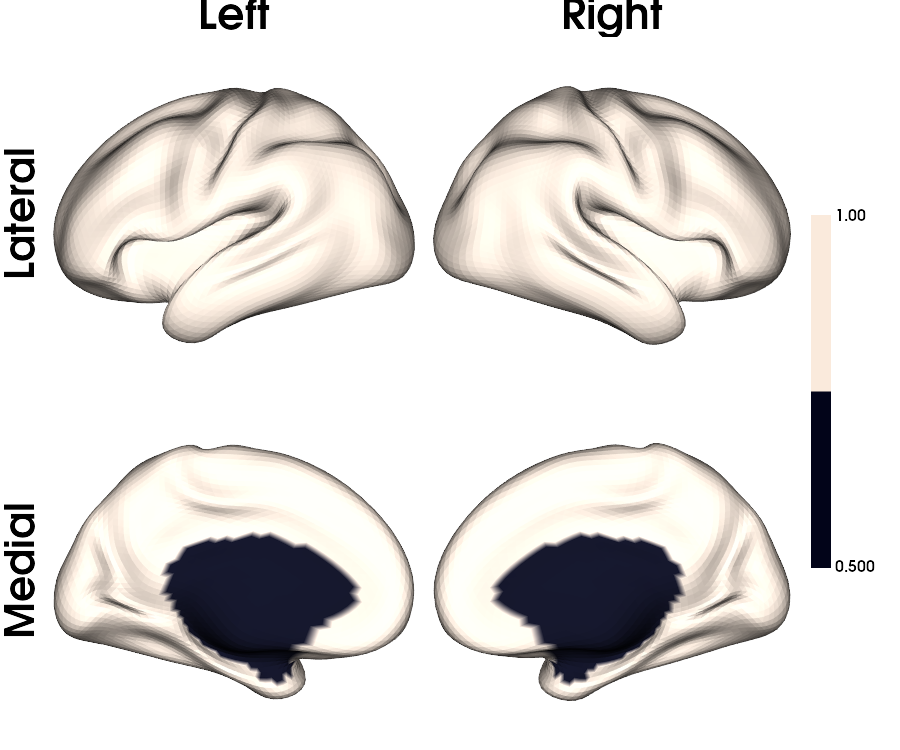

In [4]:
# Set dataset PNI as working directory
os.chdir('/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0')

# Load thickness to make a better mask
lh_files = sorted(glob.glob('sub-PNC*/ses-01/maps/*_hemi-L_surf-fsLR-5k_label-thickness.func.gii'))
rh_files = sorted(glob.glob('sub-PNC*/ses-01/maps/*_hemi-R_surf-fsLR-5k_label-thickness.func.gii'))

# Load all the thickness data
Nth=np.concatenate((nb.load(lh_files[0]).darrays[0].data, nb.load(rh_files[0]).darrays[0].data), axis=0).shape[0]

surf_map=np.empty([len(lh_files), Nth], dtype=float)
for i, _ in enumerate(lh_files):
    surf_map[i,:] = np.hstack(np.concatenate((nb.load(lh_files[i]).darrays[0].data, nb.load(rh_files[i]).darrays[0].data), axis=0))
    # Mean matrix across the x axis (vertices)
    map_mean = np.mean(surf_map, axis=0)

#mask_5k = np.where(map_mean<0.3,False, True)
plot_hemispheres(inf_lh, inf_rh, array_name=mask_5k, cmap='rocket', nan_color=(0, 0, 0, 1),
                              zoom=1.3, size=(900, 750), embed_nb=True,
                              color_bar='right', layout_style='grid', color_range=(0.5,1),
                              label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']},
                              screenshot=False)

## fsLR-5k qMRI maps

In [5]:
# load stuff
from brainspace.datasets import load_mask
mask_32k = load_mask(join=True)

inf32_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf32_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

In [15]:
def load_qmri_group(qmri=''):
    '''
    This function loads and plots the qMRI intensity maps on fsLR5k midthickness
    '''
    # List the files
    files_lh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-L_surf-fsLR-5k_label-swm1.0mm_{qmri}.func.gii"))
    files_rh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-R_surf-fsLR-5k_label-swm1.0mm_{qmri}.func.gii"))

    print(files_lh)
    # Load all the thickness data
    Nqmri=np.concatenate((nb.load(files_lh[0]).darrays[0].data, nb.load(files_rh[0]).darrays[0].data), axis=0).shape[0]

    surf_map=np.empty([len(files_lh), Nqmri], dtype=float)
    for i, _ in enumerate(files_lh):
        surf_map[i,:] = np.hstack(f)

        # Mean matrix across the x axis (vertices)
        map_mean = np.mean(surf_map, axis=0)
    N = surf_map.shape[0]
    print(f"Numer of {qmri} maps: {N}")               
    return(map_mean,surf_map)

def plot_qmri_int(qmri='', midwall_mask=False, cmap='rocket', horiz=False, rq=(0.01, 0.99)):
    map_mean,_ = load_qmri_group(qmri)
    
    #map_mean_normalized = (map_mean - np.min(map_mean)) / (np.max(map_mean) - np.min(map_mean))
    
    # Plot the group T1map intensitites
    crange=(np.quantile(map_mean[mask_5k], rq[0]), np.quantile(map_mean[mask_5k], rq[1]))

    # Replace values in f with NaN where mask_5k is False
    if midwall_mask == True: map_mean[mask_5k == False] = np.nan
    
    if horiz == True:
        fig = plot_hemispheres(inf32_rh, inf32_lh, array_name=map_mean, size=(900, 250), color_bar='right', zoom=1.25, embed_nb=True, interactive=False, share='both',
                     nan_color=(0, 0, 0, 1), cmap=cmap, color_range=crange, transparent_bg=False, screenshot = False)

    else:
        fig = plot_hemispheres(inf32_lh, inf32_rh, array_name=map_mean, cmap=cmap, nan_color=(0, 0, 0, 1),
                  zoom=1.3, size=(900, 750), embed_nb=True, color_bar='right', layout_style='grid', color_range=crange,
                  label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']}, screenshot=False)
        
    return(fig)

['sub-PNC019/ses-01/maps/sub-PNC019_ses-01_hemi-L_surf-fsLR-5k_label-swm1.0mm_T1map.func.gii', 'sub-PNC019/ses-03/maps/sub-PNC019_ses-03_hemi-L_surf-fsLR-5k_label-swm1.0mm_T1map.func.gii']
Numer of T1map maps: 2


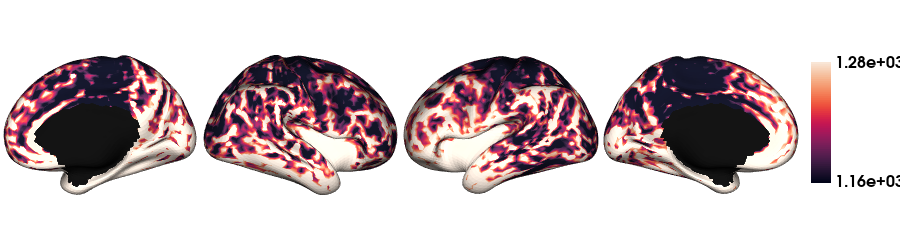

In [12]:
plot_qmri_int(qmri='T1map', midwall_mask=True, cmap='rocket', horiz=True)

## Microstructural profile by SWM depth

In [21]:
def load_qmri_group(qmri=''):
    depths = [1.0, 2.0, 3.0]
    map_means = []  # List to store map_mean values for each depth

    for depth in depths:
        # List the files
        files_lh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-L_surf-fsLR-5k_label-swm{depth}mm_{qmri}.func.gii"))
        files_rh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-R_surf-fsLR-5k_label-swm{depth}mm_{qmri}.func.gii"))

        # Load all the thickness data
        Nqmri = np.concatenate((nb.load(files_lh[0]).darrays[0].data, nb.load(files_rh[0]).darrays[0].data), axis=0).shape[0]

        surf_map = np.empty([len(files_lh), Nqmri], dtype=float)
        for i, _ in enumerate(files_lh):
            surf_map[i, :] = np.hstack(np.concatenate((nb.load(files_lh[i]).darrays[0].data, nb.load(files_rh[i]).darrays[0].data), axis=0))

        # Mean matrix across the x-axis (vertices)
        map_mean = np.mean(surf_map, axis=0)
        #map_mean[mask_5k == False] = np.nan

        # Remove rows with NaN values
        #map_mean = map_mean[~np.isnan(map_mean)]
        #print(map_mean.shape)
        
        map_means.append(map_mean)

        N = surf_map.shape[0]
        print(f"Number of {qmri} maps for depth {depth}: {N}")

    return map_means

Number of T1map maps for depth 1.0: 2
Number of T1map maps for depth 2.0: 2
Number of T1map maps for depth 3.0: 2


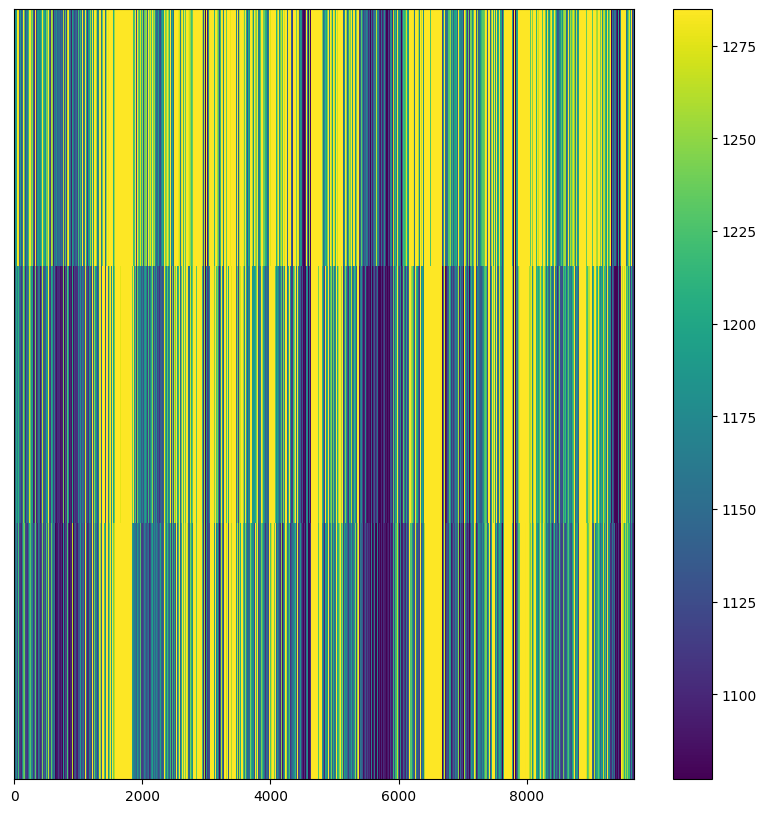

In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl

#depth_list = ['0.5mm', '1.0mm', '1.5mm', '2.0mm', '2.5mm', '3.0mm']

result = load_qmri_group(qmri='T1map')
result_matrix = np.array(result)

# Calculate the quantiles for the color range
map_crange=(np.quantile(result_matrix[:, mask_5k], 0.01), np.quantile(result_matrix[:, mask_5k], 0.99))

# Adjust the figure size as per your requirement
plt.figure(figsize=(10, 10))  # Adjust the values (width, height) as needed

# Plot the pcolormesh
pcm = plt.pcolormesh(np.flipud(result_matrix), cmap='viridis', shading='auto', vmin=map_crange[0], vmax=map_crange[1])
#plt.yticks(np.arange(len(depth_list)) + 0.5, depth_list)

# Set colorbar scale to display only the minimum and maximum values
plt.colorbar(label='')

# Set labels
#plt.xlabel('Vertices')
plt.yticks([])  # Remove y-axis labels

plt.show()

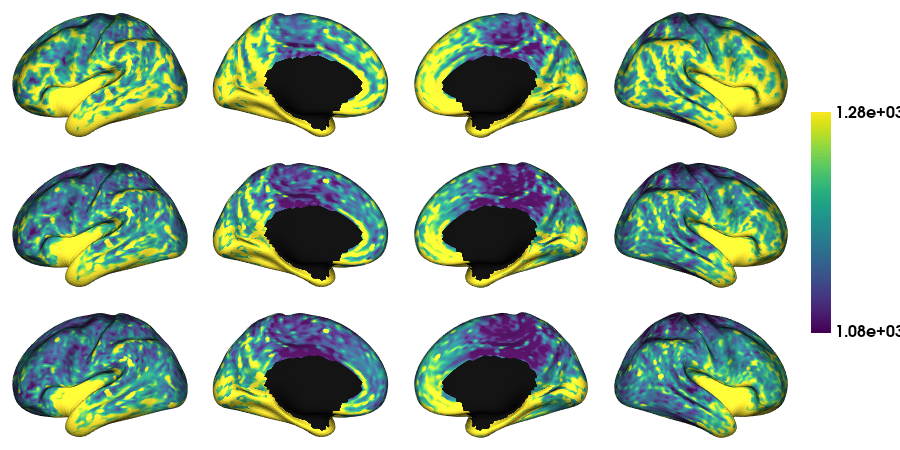

In [24]:
result_array = np.array(result)

# Calculate the quantiles for the color range
map_crange=(np.quantile(result_array[:, mask_5k], 0), np.quantile(result_array[:, mask_5k], 1))

result_array[:, mask_5k == False] = np.nan

# Plot with the new color range
plot_hemispheres(inf32_lh, inf32_rh, array_name=result_array, size=(900, 450), color_bar='right', zoom=1.5, embed_nb=True, interactive=False, share='both', nan_color=(0, 0, 0, 1), 
                 cmap='viridis', transparent_bg=False, screenshot=False, color_range=map_crange)

In [25]:
print(map_crange)

(1077.0804443359375, 1284.8450317382812)


## Correlation matrix between group mean intensity (Average)

In [30]:
def load_qmri_group(qmri=''):
    depths = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
    map_means = []  # List to store map_mean values for each depth

    for depth in depths:
        # List the files
        files_lh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-L_surf-fsLR-5k_label-swm{depth}vox_{qmri}.func.gii"))
        files_rh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-R_surf-fsLR-5k_label-swm{depth}vox_{qmri}.func.gii"))

        # Load all the thickness data
        Nqmri = np.concatenate((nb.load(files_lh[0]).darrays[0].data, nb.load(files_rh[0]).darrays[0].data), axis=0).shape[0]

        surf_map = np.empty([len(files_lh), Nqmri], dtype=float)
        for i, _ in enumerate(files_lh):
            surf_map[i, :] = np.hstack(np.concatenate((nb.load(files_lh[i]).darrays[0].data, nb.load(files_rh[i]).darrays[0].data), axis=0))

        # Mean matrix across the x-axis (vertices)
        map_mean = np.mean(surf_map, axis=0)
        map_means.append(map_mean)

        N = surf_map.shape[0]
        print(f"Number of {qmri} maps for depth {depth}: {N}")
        
        # Compute the mean across the columns
        average_map_means = np.mean(map_means, axis=0)

    return average_map_means

In [37]:
def process_qmri(qmri, cmap='rocket'):
    return load_qmri_group(qmri=qmri)

qmri_list = ['T1map', 'MTSAT', 'T2star', 'ADC', 'FA']

map_means = {}

for qmri in qmri_list:
    average_map_means = process_qmri(qmri)
    map_means[qmri] = average_map_means
    
map_means_concat = np.concatenate(
    [average_map_means[:, np.newaxis] for average_map_means in map_means.values()],
    axis=1)

# Normalize each column to be between 0 and 1
normalized_map_means = (map_means_concat - np.min(map_means_concat, axis=0)) / (np.max(map_means_concat, axis=0) - np.min(map_means_concat, axis=0))

Number of T1map maps for depth 1.0: 20
Number of T1map maps for depth 2.0: 20
Number of T1map maps for depth 3.0: 20
Number of T1map maps for depth 4.0: 20
Number of T1map maps for depth 5.0: 20
Number of T1map maps for depth 6.0: 20
Number of MTSAT maps for depth 1.0: 9
Number of MTSAT maps for depth 2.0: 9
Number of MTSAT maps for depth 3.0: 9
Number of MTSAT maps for depth 4.0: 9
Number of MTSAT maps for depth 5.0: 9
Number of MTSAT maps for depth 6.0: 9
Number of T2star maps for depth 1.0: 8
Number of T2star maps for depth 2.0: 8
Number of T2star maps for depth 3.0: 8
Number of T2star maps for depth 4.0: 8
Number of T2star maps for depth 5.0: 8
Number of T2star maps for depth 6.0: 8
Number of ADC maps for depth 1.0: 9
Number of ADC maps for depth 2.0: 9
Number of ADC maps for depth 3.0: 9
Number of ADC maps for depth 4.0: 9
Number of ADC maps for depth 5.0: 9
Number of ADC maps for depth 6.0: 9
Number of FA maps for depth 1.0: 9
Number of FA maps for depth 2.0: 9
Number of FA maps 

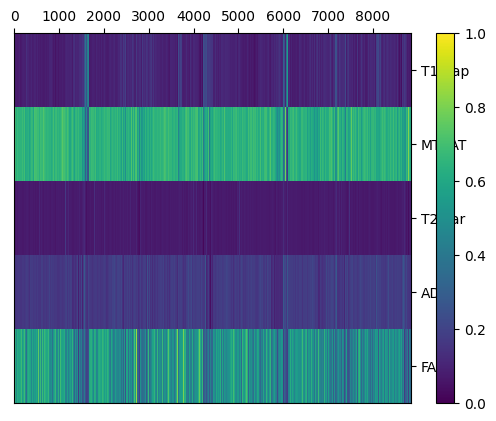

In [38]:
import matplotlib.pyplot as plt
import matplotlib as mpl

qmri_list = ['FA', 'ADC', 'T2star', 'MTSAT', 'T1map']

normalized_map_means.T[:, mask_5k == False] = np.nan

# Replace NaN values with 0
#normalized_map_means = np.nan_to_num(normalized_map_means, nan=0)

# Identify rows with NaN values and exclude them
valid_rows = ~np.isnan(normalized_map_means).any(axis=1)
normalized_map_means = normalized_map_means[valid_rows, :]

# Calculate the quantiles for the color range
#map_crange=(np.quantile(normalized_map_means.T[:, mask_5k], 0.01), np.quantile(normalized_map_means.T[:, mask_5k], 0.99))

plt.pcolormesh(np.flipud(normalized_map_means.T), cmap='viridis', shading='auto', vmin=0, vmax=1)
#vmin=map_crange[0], vmax=map_crange[1]
plt.yticks(np.arange(len(qmri_list)) + 0.5, qmri_list)
plt.colorbar(label='')

#plt.xlabel('Cortical Vertex')
#plt.ylabel('qMRI')

mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.labeltop'] = True
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False

mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.labelright'] = True
mpl.rcParams['ytick.left'] = False
mpl.rcParams['ytick.labelleft'] = False


plt.show()

In [102]:
!pip install cmocean

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 3.2 MB/s eta 0:00:0031m14.1 MB/s eta 0:00:01


In [192]:
map_means_concat.shape

(9684, 5)

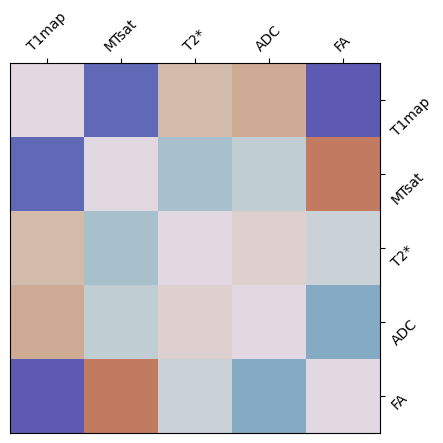

In [39]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
#import matplotlib as mpl

qmri_list = ['T1map', 'MTsat', 'T2*', 'ADC', 'FA']

map_means_concat.T[:, mask_5k == False] = np.nan

# Identify rows with NaN values and exclude them
valid_rows = ~np.isnan(map_means_concat).any(axis=1)
map_means_concat = map_means_concat[valid_rows, :]

#correlation_matrix = np.corrcoef(map_means_concat.T) # Calculate Pearson correlation
correlation_matrix, _ = spearmanr(map_means_concat) # Calculate Spearman correlation 

# Set the diagonal values to 0
np.fill_diagonal(correlation_matrix, 0)

plt.imshow(correlation_matrix, cmap='twilight_shifted', vmin=-1, vmax=1, aspect='equal')
#plt.colorbar()
plt.xticks(np.arange(len(qmri_list)), qmri_list, rotation=45)
plt.yticks(np.arange(len(qmri_list)), qmri_list, rotation=45)

mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.labeltop'] = True
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False

mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.labelright'] = True
mpl.rcParams['ytick.left'] = False
mpl.rcParams['ytick.labelleft'] = False

plt.show()

In [205]:
correlation_matrix

array([[ 0.        , -0.54402979,  0.16797856,  0.22152148, -0.59556368],
       [-0.54402979,  0.        , -0.19401008, -0.1300269 ,  0.37961601],
       [ 0.16797856, -0.19401008,  0.        ,  0.08185012, -0.10258986],
       [ 0.22152148, -0.1300269 ,  0.08185012,  0.        , -0.29727782],
       [-0.59556368,  0.37961601, -0.10258986, -0.29727782,  0.        ]])

## Differences by SWM depth

In [271]:
def load_qmri_group(qmri=''):
    depths = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
    map_means = []  # List to store map_mean values for each depth

    for depth in depths:
        # List the files
        files_lh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-L_surf-fsLR-5k_label-swm{depth}vox_{qmri}.func.gii"))
        files_rh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-R_surf-fsLR-5k_label-swm{depth}vox_{qmri}.func.gii"))

        # Load all the thickness data
        Nqmri = np.concatenate((nb.load(files_lh[0]).darrays[0].data, nb.load(files_rh[0]).darrays[0].data), axis=0).shape[0]

        surf_map = np.empty([len(files_lh), Nqmri], dtype=float)
        for i, _ in enumerate(files_lh):
            surf_map[i, :] = np.hstack(np.concatenate((nb.load(files_lh[i]).darrays[0].data, nb.load(files_rh[i]).darrays[0].data), axis=0))

        # Mean matrix across the x-axis (vertices)
        map_mean = np.mean(surf_map, axis=0)
        map_mean[mask_5k == False] = np.nan

        # Remove rows with NaN values
        map_mean = map_mean[~np.isnan(map_mean)]
        print(map_mean.shape)
        
        map_means.append(map_mean)

        N = surf_map.shape[0]
        print(f"Number of {qmri} maps for depth {depth}: {N}")
        
        # Compute the mean across the columns
        average_map_means = np.mean(map_means, axis=0)

    return map_means

In [231]:
map_mean.shape

(9684,)

(8856,)
Number of T2star maps for depth 1.0: 8
(8856,)
Number of T2star maps for depth 2.0: 8
(8856,)
Number of T2star maps for depth 3.0: 8
(8856,)
Number of T2star maps for depth 4.0: 8
(8856,)
Number of T2star maps for depth 5.0: 8
(8856,)
Number of T2star maps for depth 6.0: 8
2023-11-30 16:05:18,095 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


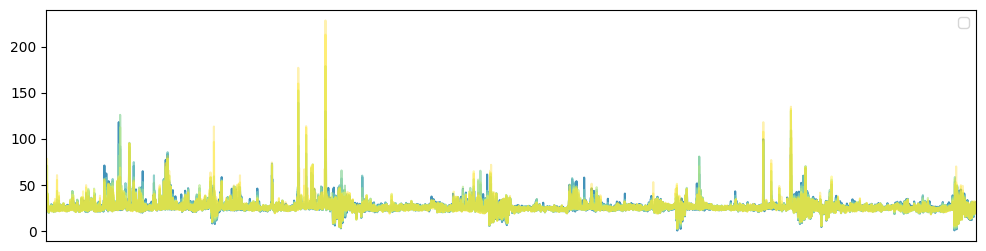

In [273]:
import matplotlib.pyplot as plt

def plot_qmri_group(map_means):
    depths = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

    # Adjust the figure size for a wider graph
    plt.figure(figsize=(12, 3))

    # Set the background color to gray
    #plt.gca().set_facecolor('lightgray')

     # Define custom RGB colors for each depth
    colors = [(66, 146, 185, 255), (112, 196, 188, 200), (143, 215, 159, 180), (178, 231, 130, 150), (255, 245, 78, 120), (254, 211, 3, 80)]
    
    for i, depth in enumerate(depths):
    #reversed(list(enumerate(depths))):
        color = (colors[i][0]/255, colors[i][1]/255, colors[i][2]/255, colors[i][3]/255)
        plt.plot(map_means[i], color=color)
        #label=f'SWM {depth} mm'

    # Set x-axis range from 0 to the maximum vertex index
    max_vertex_index = len(map_means[0]) - 1
    plt.xlim(0, max_vertex_index)
    
    #plt.title('Comparison of Intensity for Different Depths')
    plt.legend()
    plt.show()

# Assuming you have already loaded the map_means data
map_means_data = load_qmri_group(qmri='T2star')
plot_qmri_group(map_means_data)

mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False

mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.labelright'] = False
mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.labelleft'] = True

Number of FA maps for depth 1.0: 9
Number of FA maps for depth 2.0: 9
Number of FA maps for depth 3.0: 9
Number of FA maps for depth 4.0: 9
Number of FA maps for depth 5.0: 9
Number of FA maps for depth 6.0: 9
2023-11-30 01:05:24,043 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


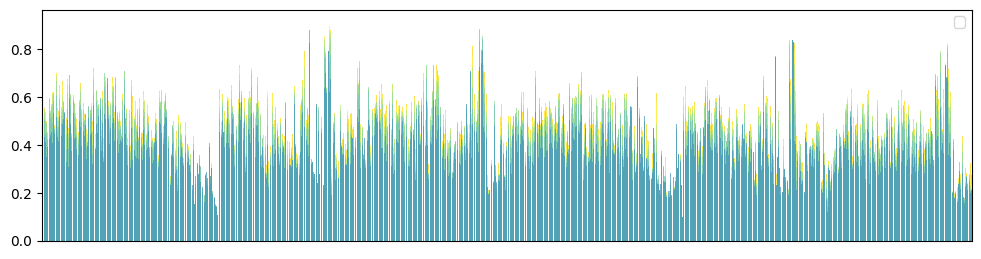

In [36]:
import matplotlib.pyplot as plt

def plot_qmri_group(map_means):
    depths = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

    # Adjust the figure size for a wider graph
    plt.figure(figsize=(12, 3))

    # Set the background color to gray
    #plt.gca().set_facecolor('lightgray')

     # Define custom RGB colors for each depth
    #colors = [(66, 146, 185, 255), (112, 196, 188, 200), (143, 215, 159, 150), (178, 231, 130, 100), (255, 245, 78, 80), (254, 211, 3, 20)]
    colors = [(66, 146, 185, 20), (112, 196, 188, 80), (143, 215, 159, 100), (178, 231, 130, 150), (255, 245, 78, 200), (254, 211, 3, 255)]

    for i, depth in reversed(list(enumerate(depths))):
    #enumerate(depths):
    #reversed(list(enumerate(depths))):
        color = (colors[i][0]/255, colors[i][1]/255, colors[i][2]/255, colors[i][3]/255)
        plt.bar(range(len(map_means[i])), map_means[i], color=color, alpha=0.7)
        #label=f'SWM {depth} mm'

    # Set x-axis range from 0 to the maximum vertex index
    max_vertex_index = len(map_means[0]) - 1
    plt.xlim(0, max_vertex_index)
    
    #plt.title('Comparison of Intensity for Different Depths')
    plt.legend()
    plt.show()

# Assuming you have already loaded the map_means data
map_means_data = load_qmri_group(qmri='FA')
plot_qmri_group(map_means_data)

mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False

mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.labelright'] = False
mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.labelleft'] = True

Number of FA maps for depth 1.0: 9
Number of FA maps for depth 2.0: 9
Number of FA maps for depth 3.0: 9
Number of FA maps for depth 4.0: 9
Number of FA maps for depth 5.0: 9
Number of FA maps for depth 6.0: 9
2023-11-30 01:08:52,324 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


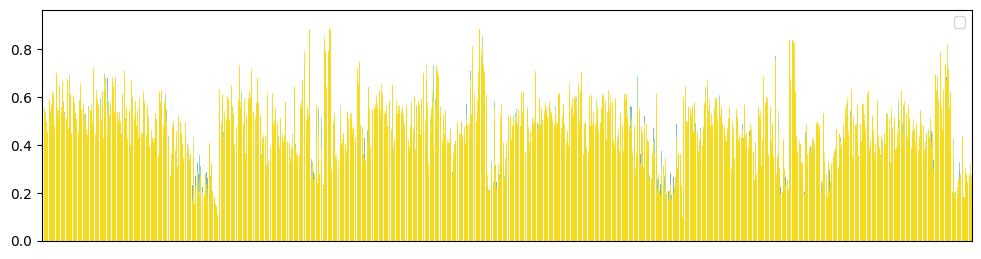

In [38]:
import matplotlib.pyplot as plt

def plot_qmri_group(map_means):
    depths = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

    # Adjust the figure size for a wider graph
    plt.figure(figsize=(12, 3))

    # Set the background color to gray
    #plt.gca().set_facecolor('lightgray')

     # Define custom RGB colors for each depth
    colors = [(66, 146, 185, 255), (112, 196, 188, 200), (143, 215, 159, 150), (178, 231, 130, 100), (255, 245, 78, 80), (254, 211, 3, 20)]
    #colors = [(66, 146, 185, 20), (112, 196, 188, 80), (143, 215, 159, 100), (178, 231, 130, 150), (255, 245, 78, 200), (254, 211, 3, 255)]

    for i, depth in enumerate(depths):
    #enumerate(depths):
    #reversed(list(enumerate(depths))):
        color = (colors[i][0]/255, colors[i][1]/255, colors[i][2]/255, colors[i][3]/255)
        plt.bar(range(len(map_means[i])), map_means[i], color=color, alpha=0.7)
        #label=f'SWM {depth} mm'

    # Set x-axis range from 0 to the maximum vertex index
    max_vertex_index = len(map_means[0]) - 1
    plt.xlim(0, max_vertex_index)
    
    #plt.title('Comparison of Intensity for Different Depths')
    plt.legend()
    plt.show()

# Assuming you have already loaded the map_means data
map_means_data = load_qmri_group(qmri='FA')
plot_qmri_group(map_means_data)

mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False

mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.labelright'] = False
mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.labelleft'] = True

## Correlation matrix between group mean intensity (by depth)

In [52]:
def process_qmri(qmri, cmap='rocket'):
    return load_qmri_group(qmri=qmri)

qmri_list = ['T1map', 'MTR', 'MTSAT', 'ADC', 'FA']

map_means = {}

for qmri in qmri_list:
    map_mean = process_qmri(qmri)
    map_means[qmri] = map_mean
    
map_means_concat = np.concatenate(
    [map_mean[:, np.newaxis] for map_mean in map_means.values()],
    axis=1)

# Normalize each column to be between 0 and 1
normalized_map_means = (map_means_concat - np.min(map_means_concat, axis=0)) / (np.max(map_means_concat, axis=0) - np.min(map_means_concat, axis=0))

Numer of T1map maps: 10
Numer of MTR maps: 9
Numer of MTSAT maps: 9
Numer of ADC maps: 1
Numer of FA maps: 1


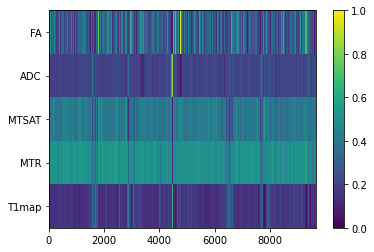

In [56]:
import matplotlib.pyplot as plt
import matplotlib as mpl

qmri_list = ['T1map', 'MTR', 'MTSAT', 'ADC', 'FA']

plt.pcolormesh(normalized_map_means.T, cmap='viridis', shading='auto')
plt.yticks(np.arange(len(qmri_list)) + 0.5, qmri_list)
plt.colorbar(label='')

#plt.xlabel('Cortical Vertex')
#plt.ylabel('qMRI')

mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['xtick.labelbottom'] = True

plt.show()

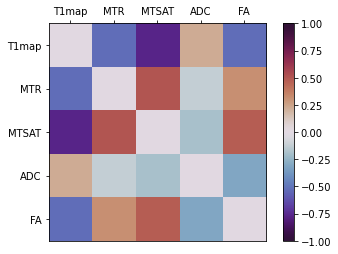

In [32]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
#import matplotlib as mpl

qmri_list = ['T1map', 'MTR', 'MTSAT', 'ADC', 'FA']

#correlation_matrix = np.corrcoef(map_means_concat.T) # Calculate Pearson correlation
correlation_matrix, _ = spearmanr(map_means_concat) # Calculate Spearman correlation 

# Set the diagonal values to 0
np.fill_diagonal(correlation_matrix, 0)

plt.imshow(correlation_matrix, cmap='twilight_shifted', vmin=-1, vmax=1, aspect='equal')
plt.colorbar()
plt.xticks(np.arange(len(qmri_list)), qmri_list)
plt.yticks(np.arange(len(qmri_list)), qmri_list)

mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.labeltop'] = True
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False

plt.show()

## Group Similarity

In [339]:
def load_qmri_group(qmri=''):
    depth_values = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
    
    # Initialize the total_surf_map to accumulate the matrices
    total_surf_map = None

    for depth in depth_values:
        # List the files
        files_lh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-L_surf-fsLR-5k_label-swm{depth}vox_{qmri}.func.gii"))
        files_rh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-R_surf-fsLR-5k_label-swm{depth}vox_{qmri}.func.gii"))

        # Load all the thickness data
        Nqmri = np.concatenate((nb.load(files_lh[0]).darrays[0].data, nb.load(files_rh[0]).darrays[0].data), axis=0).shape[0]

        surf_map = np.empty([len(files_lh), Nqmri], dtype=float)

        for i, _ in enumerate(files_lh):
            surf_map[i, :] = np.hstack(np.concatenate((nb.load(files_lh[i]).darrays[0].data, nb.load(files_rh[i]).darrays[0].data), axis=0))

        # Accumulate the matrices
        if total_surf_map is None:
            total_surf_map = surf_map
        else:
            total_surf_map += surf_map

    # Mean matrix across the x axis (vertices)
    map_mean = np.mean(total_surf_map, axis=0)
    N = total_surf_map.shape[0]
    print(f"Number of {qmri} maps: {N}")
    return total_surf_map, map_mean

In [336]:
# T1map (10 subject - only ses-03)
T1map_data, T1map_mean_matrix = load_qmri_group(qmri='T1map')
# delete sub-PNC015 (9 subject)
T1map_data = np.delete(T1map_data, 6, axis=0)

Number of T1map maps: 10


In [340]:
# FA (9 subject- ses-*)
FA_data, FA_mean_matrix = load_qmri_group(qmri='FA')

# MTSAT (9 subject - ses-*)
MTSAT_data, MTSAT_mean_matrix = load_qmri_group(qmri='MTSAT')

Number of FA maps: 9
Number of MTSAT maps: 9


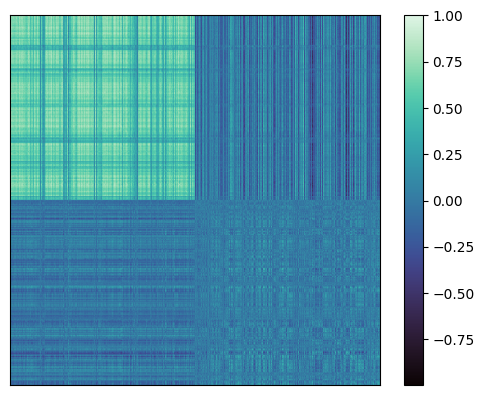

In [341]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Calculate the correlation coefficients
correlation_matrix = np.corrcoef(MTSAT_data.T, FA_data.T)

plt.imshow(correlation_matrix, cmap='mako', aspect='equal')
plt.colorbar(label='')

mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False

mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.labelright'] = False
mpl.rcParams['ytick.left'] = False
mpl.rcParams['ytick.labelleft'] = False

plt.show()

In [63]:
print(T1map_data.shape)
print(FA_data.shape)

(9, 9684)
(9, 9684)


### T1map - FA Correlation Matrix

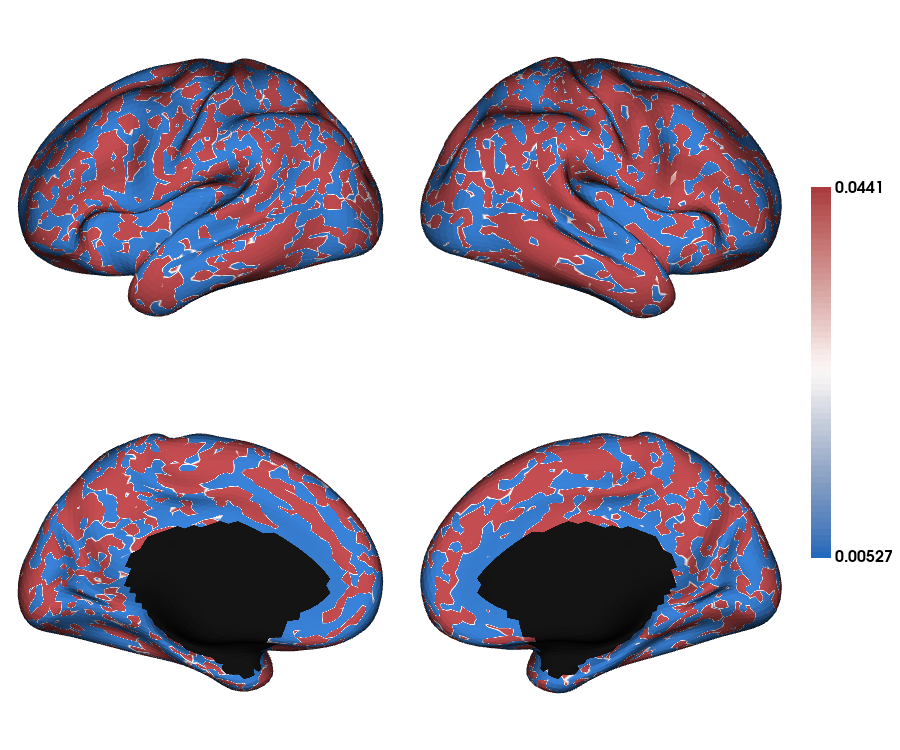

In [342]:
# Calculate the correlation coefficients
correlation_matrix = np.corrcoef(T1map_data.T, FA_data.T)

# Extract the correlation values between the two matrices
vertex_wise_correlation = correlation_matrix[:T1map_data.shape[1], T1map_data.shape[1]:]

# Calculate the mean for each column
corr_means = np.mean(vertex_wise_correlation, axis=0)

# Set your desired color range (replace min_value and max_value)
new_crange = (-0.3, 0.3)
# Calculate the quantiles for the color range
map_crange=(np.quantile(corr_means.T[mask_5k], 0.01), np.quantile(corr_means.T[mask_5k], 0.99))

corr_means[mask_5k == False] = np.nan

plot_hemispheres(inf32_lh, inf32_rh, array_name=corr_means, size=(900, 750), color_bar='right', zoom=1.25, embed_nb=True, interactive=False, share='both', nan_color=(0, 0, 0, 1), 
                 cmap='vlag', layout_style='grid', transparent_bg=False, screenshot=False, color_range=map_crange)

In [343]:
T1map_data.shape

(9, 9684)

### T1map - MTSAT Correlation Matrix

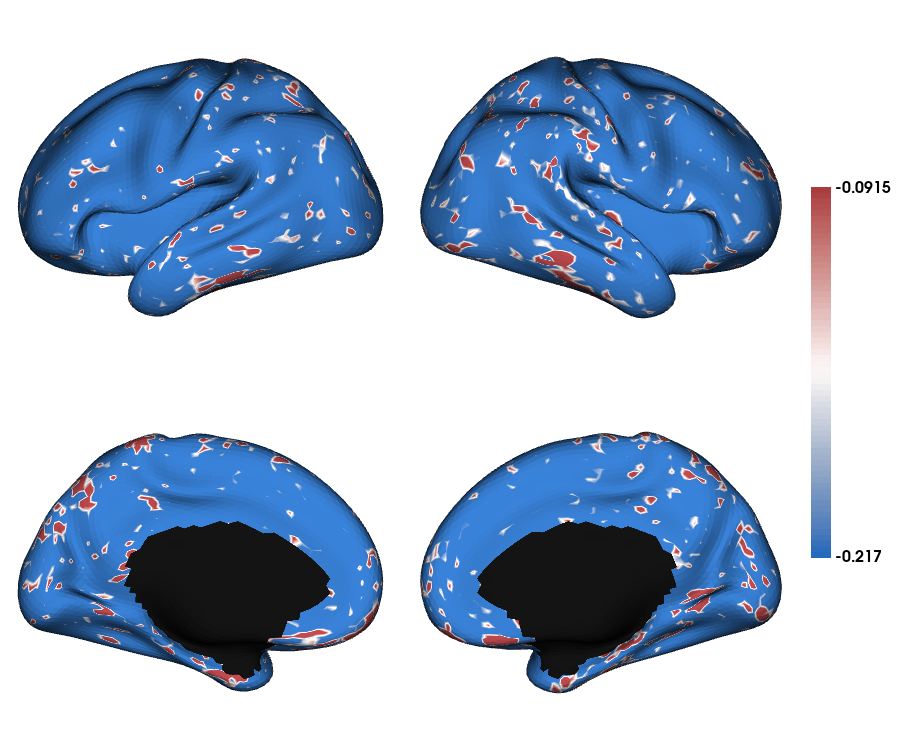

In [166]:
# Calculate the correlation coefficients
correlation_matrix = np.corrcoef(T1map_data.T, MTSAT_data.T)

# Extract the correlation values between the two matrices
vertex_wise_correlation = correlation_matrix[:T1map_data.shape[1], T1map_data.shape[1]:]

# Calculate the mean for each column
corr_means = np.mean(vertex_wise_correlation, axis=0)

# Set your desired color range (replace min_value and max_value)
new_crange = (-0.5, 0.3)
# Calculate the quantiles for the color range
map_crange=(np.quantile(corr_means.T[mask_5k], 0.01), np.quantile(corr_means.T[mask_5k], 0.99))


corr_means[mask_5k == False] = np.nan

plot_hemispheres(inf32_lh, inf32_rh, array_name=corr_means, size=(900, 750), color_bar='right', zoom=1.25, embed_nb=True, interactive=False, share='both', nan_color=(0, 0, 0, 1), 
                 cmap='vlag', layout_style='grid', transparent_bg=False, screenshot=False, color_range=map_crange)

### T1map - FA Correlation Matrix

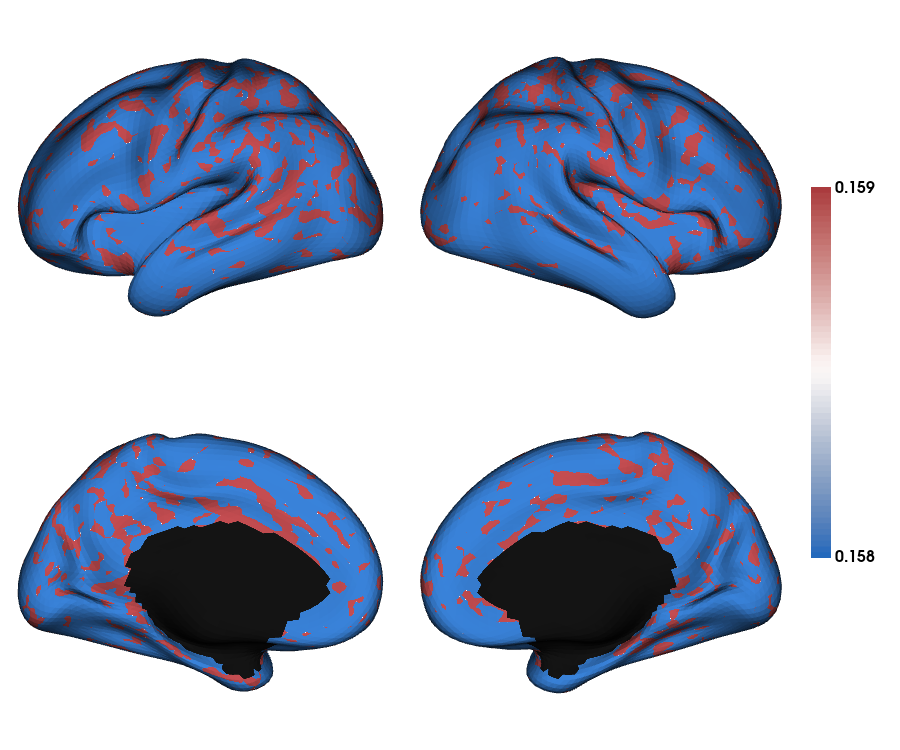

In [167]:
# Calculate the correlation coefficients
correlation_matrix = np.corrcoef(MTSAT_data.T, FA_data.T)

# Extract the correlation values between the two matrices
vertex_wise_correlation = correlation_matrix[:MTSAT_data.shape[1], MTSAT_data.shape[1]:]

# Calculate the mean for each column
corr_means = np.mean(vertex_wise_correlation, axis=0)

# Set your desired color range (replace min_value and max_value)
new_crange = (-0.4, 0.4)
# Calculate the quantiles for the color range
map_crange=(np.quantile(corr_means.T[mask_5k], 0.01), np.quantile(corr_means.T[mask_5k], 0.99))

corr_means[mask_5k == False] = np.nan

plot_hemispheres(inf32_lh, inf32_rh, array_name=corr_means, size=(900, 750), color_bar='right', zoom=1.25, embed_nb=True, interactive=False, share='both', nan_color=(0, 0, 0, 1), 
                 cmap='vlag', layout_style='grid', transparent_bg=False, screenshot=False, color_range=map_crange)

## Depth Similaritly

In [43]:
def load_qmri_group(qmri=''):
    depths = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
    map_means = []  # List to store map_mean values for each depth

    for depth in depths:
        # List the files
        files_lh = sorted(glob.glob(f"sub-*/ses-03/maps/*_hemi-L_surf-fsLR-5k_label-swm{depth}vox_{qmri}.func.gii"))
        files_rh = sorted(glob.glob(f"sub-*/ses-03/maps/*_hemi-R_surf-fsLR-5k_label-swm{depth}vox_{qmri}.func.gii"))

        # Load all the thickness data
        Nqmri = np.concatenate((nb.load(files_lh[0]).darrays[0].data, nb.load(files_rh[0]).darrays[0].data), axis=0).shape[0]

        surf_map = np.empty([len(files_lh), Nqmri], dtype=float)
        for i, _ in enumerate(files_lh):
            surf_map[i, :] = np.hstack(np.concatenate((nb.load(files_lh[i]).darrays[0].data, nb.load(files_rh[i]).darrays[0].data), axis=0))

        # Mean matrix across the x-axis (vertices)
        map_mean = np.mean(surf_map, axis=0)
        map_mean[mask_5k == False] = np.nan

        # Remove rows with NaN values
        map_mean = map_mean[~np.isnan(map_mean)]
        #print(map_mean.shape)
        
        map_means.append(map_mean)

        N = surf_map.shape[0]
        print(f"Number of {qmri} maps for depth {depth}: {N}")

    return map_means

In [44]:
# T1map (10 subject - only ses-03)
T1map_depth_data = load_qmri_group(qmri='T1map')
T1map_depth_data = np.array(T1map_depth_data)

Number of T1map maps for depth 1.0: 10
Number of T1map maps for depth 2.0: 10
Number of T1map maps for depth 3.0: 10
Number of T1map maps for depth 4.0: 10
Number of T1map maps for depth 5.0: 10
Number of T1map maps for depth 6.0: 10


In [8]:
T1map_depth_data.shape

(6, 9684)

In [42]:
# FA (9 subject- ses-*)
FA_depth_data = load_qmri_group(qmri='FA')
FA_depth_data = np.array(FA_depth_data)

# MTSAT (9 subject - ses-*)
MTSAT_depth_data = load_qmri_group(qmri='MTSAT')
MTSAT_depth_data = np.array(MTSAT_depth_data)

Number of FA maps for depth 1.0: 9
Number of FA maps for depth 2.0: 9
Number of FA maps for depth 3.0: 9
Number of FA maps for depth 4.0: 9
Number of FA maps for depth 5.0: 9
Number of FA maps for depth 6.0: 9
Number of MTSAT maps for depth 1.0: 9
Number of MTSAT maps for depth 2.0: 9
Number of MTSAT maps for depth 3.0: 9
Number of MTSAT maps for depth 4.0: 9
Number of MTSAT maps for depth 5.0: 9
Number of MTSAT maps for depth 6.0: 9


In [9]:
FA_depth_data.shape

(6, 9684)

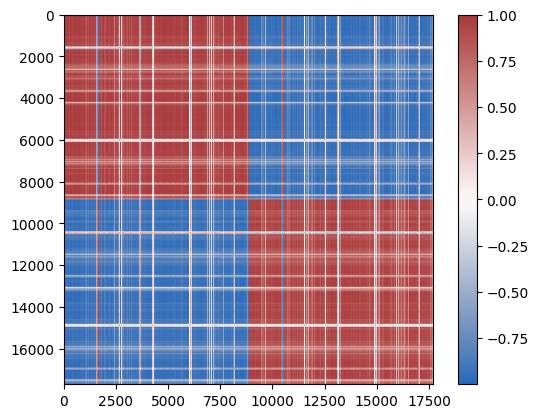

In [70]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Calculate the correlation coefficients
correlation_matrix = np.corrcoef(T1map_depth_data.T, MTSAT_depth_data.T)

plt.imshow(correlation_matrix, cmap='vlag', aspect='equal')
plt.colorbar(label='')

mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False

mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.labelright'] = False
mpl.rcParams['ytick.left'] = False
mpl.rcParams['ytick.labelleft'] = False

plt.show()

(17712, 17712)


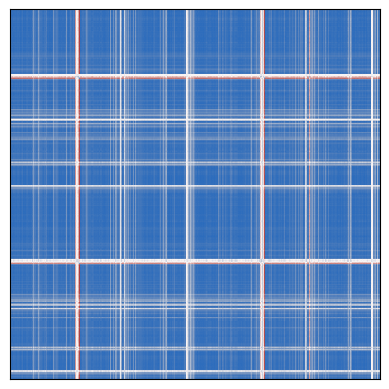

In [71]:
# Extract the correlation values between the two matrices
vertex_wise_correlation = correlation_matrix[:T1map_depth_data.shape[1], T1map_depth_data.shape[1]:]

plt.imshow(vertex_wise_correlation, cmap='vlag', aspect='equal')
#plt.colorbar(label='')

mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False

mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.labelright'] = False
mpl.rcParams['ytick.left'] = False
mpl.rcParams['ytick.labelleft'] = False

print(correlation_matrix.shape)

plt.show()

/tmp/ipykernel_187565/3708580589.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('vlag')  # Choose a colormap, e.g., 'viridis'


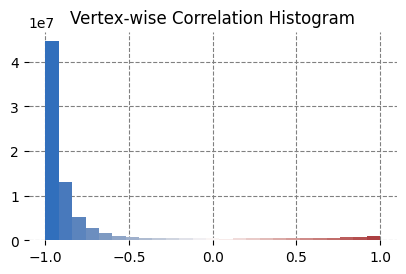

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Assuming vertex_wise_correlation is your matrix
vertex_wise_correlation = correlation_matrix[:T1map_depth_data.shape[1], T1map_depth_data.shape[1]:]

# Create the 1x2 layout for histograms
plt.figure(figsize=(8, 3))

# Left subplot - Histogram for correlation values
plt.subplot(1, 2, 1)
n, bins, _ = plt.hist(vertex_wise_correlation.flatten(), bins=25)
bin_centers = (bins[:-1] + bins[1:]) / 2  # Compute the bin centers
colormap = cm.get_cmap('vlag')  # Choose a colormap, e.g., 'viridis'
colored_bins = colormap(np.interp(bin_centers, [np.min(vertex_wise_correlation), np.max(vertex_wise_correlation)], [0, 1]))
plt.bar(bin_centers, n, width=np.diff(bins), color=colored_bins)
#plt.xlabel('Correlation Values', fontsize=10)
#plt.ylabel('Frequency', fontsize=10)
plt.title('Vertex-wise Correlation Histogram', fontsize=12)

# Remove the outer box line
for spine in plt.gca().spines.values():
    spine.set_visible(False)
# Set the grid on the back
plt.gca().set_axisbelow(True)
plt.grid(color='gray', linestyle='dashed')

# Right subplot - Customize as needed
# ...

mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['xtick.labelbottom'] = True

mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.labelright'] = False
mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.labelleft'] = True

plt.tight_layout()  # Adjust the spacing between subplots
# Save the plot as an image file (e.g., PNG or PDF)
#plt.savefig('correlation_histogram.png')
plt.show()

## For Atlas

In [4]:
def load_qmri_group(qmri=''):
    depths = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
    map_means = []  # List to store map_mean values for each depth

    for depth in depths:
        # List the files
        files_lh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-L_surf-fsLR-5k_label-swm{depth}vox_{qmri}.func.gii"))
        files_rh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-R_surf-fsLR-5k_label-swm{depth}vox_{qmri}.func.gii"))

        # Load all the thickness data
        Nqmri = np.concatenate((nb.load(files_lh[0]).darrays[0].data, nb.load(files_rh[0]).darrays[0].data), axis=0).shape[0]

        surf_map = np.empty([len(files_lh), Nqmri], dtype=float)
        for i, _ in enumerate(files_lh):
            surf_map[i, :] = np.hstack(np.concatenate((nb.load(files_lh[i]).darrays[0].data, nb.load(files_rh[i]).darrays[0].data), axis=0))

        # Mean matrix across the x-axis (vertices)
        map_mean = np.mean(surf_map, axis=0)
        map_means.append(map_mean)

        N = surf_map.shape[0]
        print(f"Number of {qmri} maps for depth {depth}: {N}")

    return map_means

In [5]:
# T1map (10 subject - only ses-03)
T1map_depth_data = load_qmri_group(qmri='T1map')
T1map_depth_data = np.array(T1map_depth_data)

# FA (9 subject- ses-*)
FA_depth_data = load_qmri_group(qmri='FA')
FA_depth_data = np.array(FA_depth_data)

# MTSAT (9 subject - ses-*)
MTSAT_depth_data = load_qmri_group(qmri='MTSAT')
MTSAT_depth_data = np.array(MTSAT_depth_data)

Number of T1map maps for depth 1.0: 20
Number of T1map maps for depth 2.0: 20
Number of T1map maps for depth 3.0: 20
Number of T1map maps for depth 4.0: 20
Number of T1map maps for depth 5.0: 20
Number of T1map maps for depth 6.0: 20
Number of FA maps for depth 1.0: 9
Number of FA maps for depth 2.0: 9
Number of FA maps for depth 3.0: 9
Number of FA maps for depth 4.0: 9
Number of FA maps for depth 5.0: 9
Number of FA maps for depth 6.0: 9
Number of MTSAT maps for depth 1.0: 9
Number of MTSAT maps for depth 2.0: 9
Number of MTSAT maps for depth 3.0: 9
Number of MTSAT maps for depth 4.0: 9
Number of MTSAT maps for depth 5.0: 9
Number of MTSAT maps for depth 6.0: 9


In [363]:
#plt.imshow(T1map_depth_data)
T1map_depth_data.shape

(6, 9684)

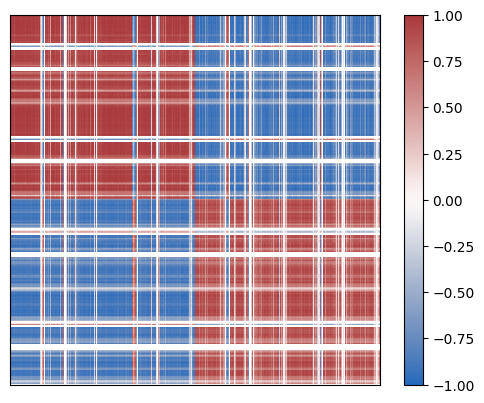

In [366]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Calculate the correlation coefficients
correlation_matrix = np.corrcoef(T1map_depth_data.T, FA_depth_data.T)

plt.imshow(correlation_matrix, cmap='vlag', aspect='equal')
plt.colorbar(label='')

mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False

mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.labelright'] = False
mpl.rcParams['ytick.left'] = False
mpl.rcParams['ytick.labelleft'] = False

plt.show()

In [346]:
T1map_depth_data.shape

(6, 9684)

### MTSAT - FA Correlation Matrix

/tmp/ipykernel_187565/2796078141.py:11: RuntimeWarning: Mean of empty slice
  corr_means = np.nanmean(vertex_wise_correlation, axis=0)


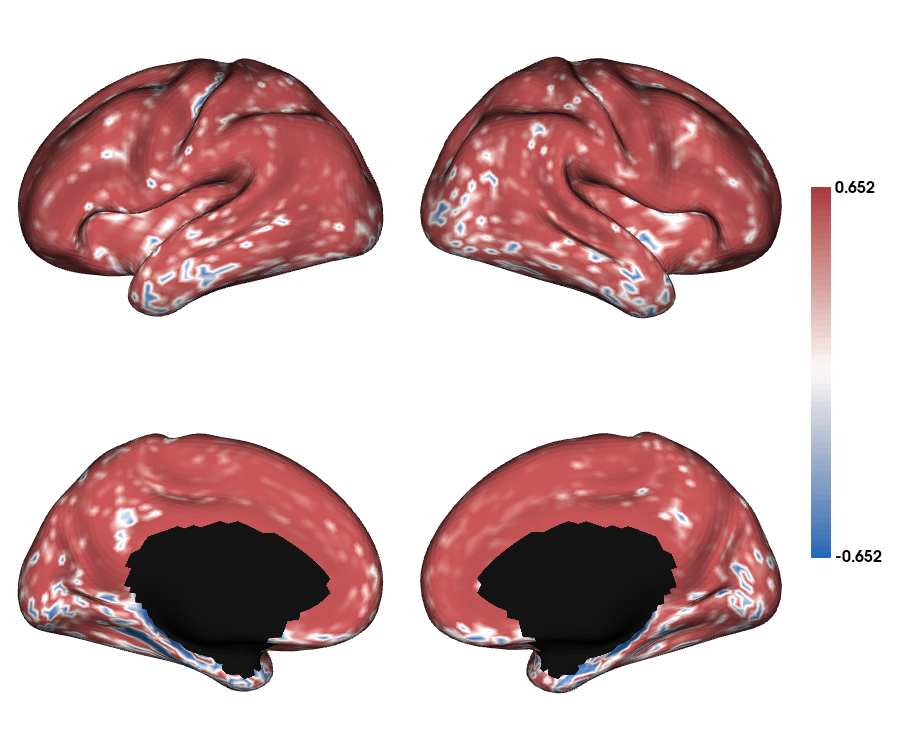

In [15]:
from scipy.stats import spearmanr

# Calculate the correlation coefficients
#correlation_matrix = np.corrcoef(MTSAT_depth_data.T, FA_depth_data.T)
correlation_matrix, _ = spearmanr(MTSAT_depth_data, FA_depth_data) # Calculate Spearman correlation 

# Extract the correlation values between the two matrices
vertex_wise_correlation = correlation_matrix[:MTSAT_depth_data.shape[1], MTSAT_depth_data.shape[1]:]

# Calculate the mean for each column
corr_means = np.nanmean(vertex_wise_correlation, axis=0)

# Calculate the quantiles for the color range
map_crange=(np.quantile(corr_means.T[mask_5k], 0.01), np.quantile(corr_means.T[mask_5k], 0.99))

corr_means[mask_5k == False] = np.nan

plot_hemispheres(inf32_lh, inf32_rh, array_name=corr_means, size=(900, 750), color_bar='right', zoom=1.25, embed_nb=True, interactive=False, share='both', nan_color=(0, 0, 0, 1), 
                 cmap='vlag', layout_style='grid', transparent_bg=False, screenshot=False)

### T1map - MTSAT Correlation Matrix

/tmp/ipykernel_187565/95239791.py:9: RuntimeWarning: Mean of empty slice
  corr_means = np.nanmean(vertex_wise_correlation, axis=0)


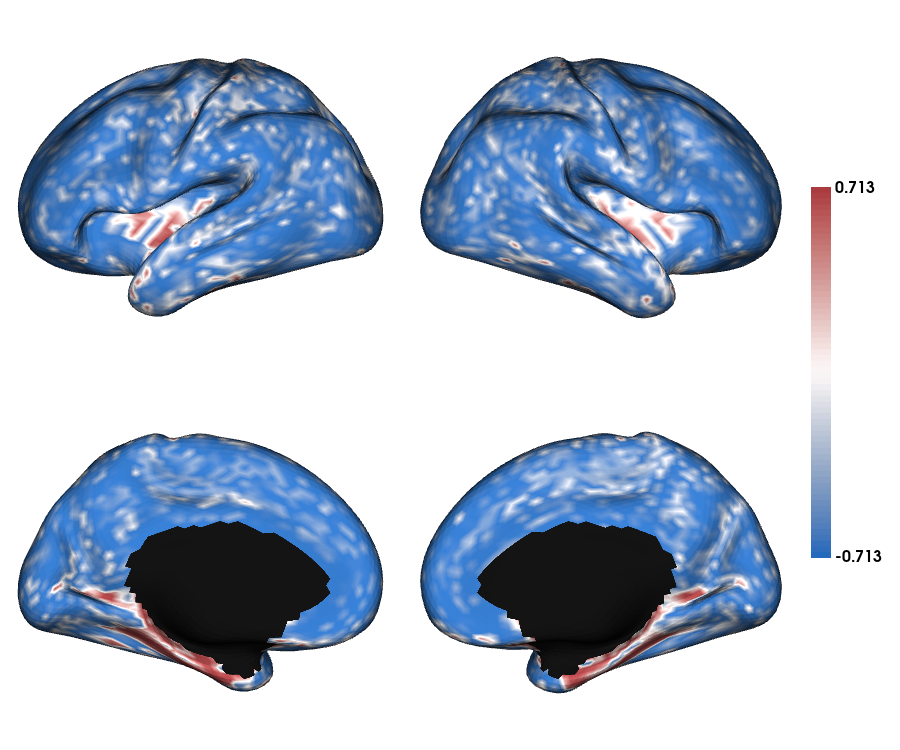

In [16]:
# Calculate the correlation coefficients
#correlation_matrix = np.corrcoef(T1map_depth_data.T, MTSAT_depth_data.T)
correlation_matrix, _ = spearmanr(T1map_depth_data, MTSAT_depth_data) # Calculate Spearman correlation

# Extract the correlation values between the two matrices
vertex_wise_correlation = correlation_matrix[:MTSAT_depth_data.shape[1], MTSAT_depth_data.shape[1]:]

# Calculate the mean for each column
corr_means = np.nanmean(vertex_wise_correlation, axis=0)

# Calculate the quantiles for the color range
map_crange=(np.quantile(corr_means.T[mask_5k], 0.01), np.quantile(corr_means.T[mask_5k], 0.99))

corr_means[mask_5k == False] = np.nan

plot_hemispheres(inf32_lh, inf32_rh, array_name=corr_means, size=(900, 750), color_bar='right', zoom=1.25, embed_nb=True, interactive=False, share='both', nan_color=(0, 0, 0, 1), 
                 cmap='vlag', layout_style='grid', transparent_bg=False, screenshot=False)

### T1map - FA Correlation Matrix

/tmp/ipykernel_187565/1845855359.py:9: RuntimeWarning: Mean of empty slice
  corr_means = np.nanmean(vertex_wise_correlation, axis=0)


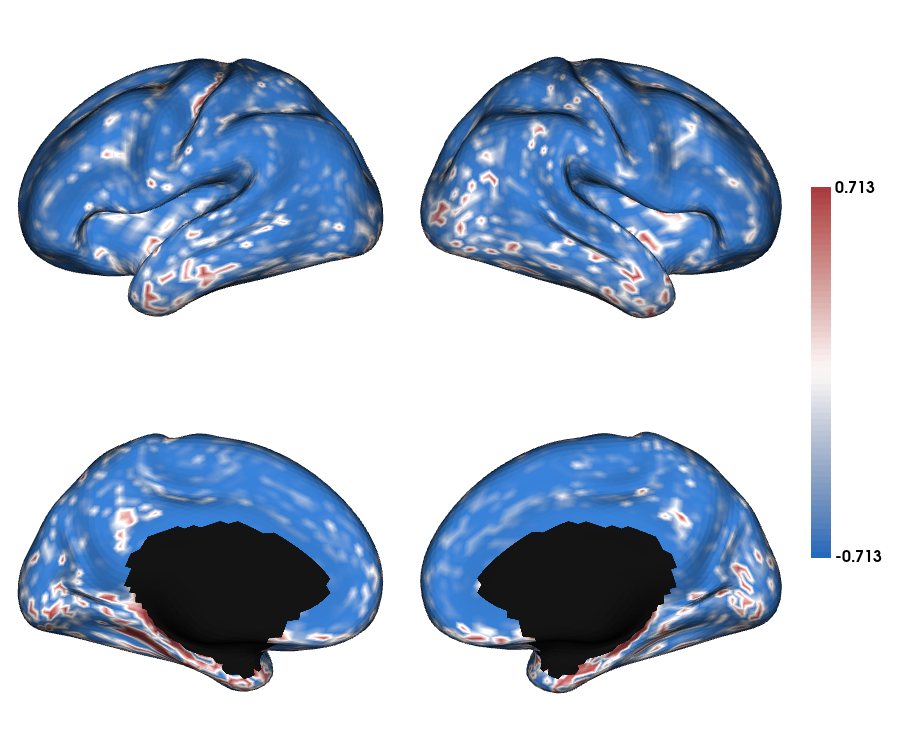

In [17]:
# Calculate the correlation coefficients
#correlation_matrix = np.corrcoef(T1map_depth_data.T, FA_depth_data.T)
correlation_matrix, _ = spearmanr(T1map_depth_data, FA_depth_data) # Calculate Spearman correlation

# Extract the correlation values between the two matrices
vertex_wise_correlation = correlation_matrix[:MTSAT_depth_data.shape[1], MTSAT_depth_data.shape[1]:]

# Calculate the mean for each column
corr_means = np.nanmean(vertex_wise_correlation, axis=0)

# Calculate the quantiles for the color range
map_crange=(np.quantile(corr_means.T[mask_5k], 0.01), np.quantile(corr_means.T[mask_5k], 0.99))

corr_means[mask_5k == False] = np.nan

plot_hemispheres(inf32_lh, inf32_rh, array_name=corr_means, size=(900, 750), color_bar='right', zoom=1.25, embed_nb=True, interactive=False, share='both', nan_color=(0, 0, 0, 1), 
                 cmap='vlag', layout_style='grid', transparent_bg=False, screenshot=False)

In [368]:
corr_means.shape

array([[-0.3840772 ,  0.28822033, -0.04511138, ..., -0.59253598,
        -0.32908704,  0.62212513],
       [ 0.70210159,  0.87059985,  0.82018378, ...,  0.58192942,
         0.72253309, -0.04075148],
       [ 0.9750205 ,  0.88646369,  0.97177016, ...,  0.60891634,
         0.81005116,  0.15478998],
       ...,
       [ 0.88774345,  0.96024212,  0.97186222, ...,  0.57100284,
         0.79505485,  0.16701996],
       [ 0.89219585,  0.96254967,  0.97640073, ...,  0.5575305 ,
         0.78761063,  0.18523884],
       [ 0.69747688,  0.98401996,  0.88955494, ...,  0.21560221,
         0.5714366 ,  0.54623032]])

In [319]:
corr_means.shape

(8856,)

### T1map - MTSAT Correlation Matrix

### MTSAT - FA Correlation Matrix

## Scatter Plot

In [31]:
def load_qmri_group(qmri=''):
    depths = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
    map_means = []  # List to store map_mean values for each depth

    for depth in depths:
        # List the files
        files_lh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-L_surf-fsLR-5k_label-swm{depth}vox_{qmri}.func.gii"))
        files_rh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-R_surf-fsLR-5k_label-swm{depth}vox_{qmri}.func.gii"))

        # Load all the thickness data
        Nqmri = np.concatenate((nb.load(files_lh[0]).darrays[0].data, nb.load(files_rh[0]).darrays[0].data), axis=0).shape[0]

        surf_map = np.empty([len(files_lh), Nqmri], dtype=float)
        for i, _ in enumerate(files_lh):
            surf_map[i, :] = np.hstack(np.concatenate((nb.load(files_lh[i]).darrays[0].data, nb.load(files_rh[i]).darrays[0].data), axis=0))

        # Mean matrix across the x-axis (vertices)
        map_mean = np.mean(surf_map, axis=0)
        map_means.append(map_mean)

        N = surf_map.shape[0]
        print(f"Number of {qmri} maps for depth {depth}: {N}")
        
        # Compute the mean across the columns
        average_map_means = np.mean(map_means, axis=0)

    return average_map_means

In [32]:
def process_qmri(qmri, cmap='rocket'):
    return load_qmri_group(qmri=qmri)

qmri_list = ['T1map', 'MTSAT', 'T2star', 'ADC', 'FA']

map_means = {}

for qmri in qmri_list:
    average_map_means = process_qmri(qmri)
    map_means[qmri] = average_map_means
    
map_means_concat = np.concatenate(
    [average_map_means[:, np.newaxis] for average_map_means in map_means.values()],
    axis=1)

# Normalize each column to be between 0 and 1
normalized_map_means = (map_means_concat - np.min(map_means_concat, axis=0)) / (np.max(map_means_concat, axis=0) - np.min(map_means_concat, axis=0))

Number of T1map maps for depth 1.0: 20
Number of T1map maps for depth 2.0: 20
Number of T1map maps for depth 3.0: 20
Number of T1map maps for depth 4.0: 20
Number of T1map maps for depth 5.0: 20
Number of T1map maps for depth 6.0: 20
Number of MTSAT maps for depth 1.0: 9
Number of MTSAT maps for depth 2.0: 9
Number of MTSAT maps for depth 3.0: 9
Number of MTSAT maps for depth 4.0: 9
Number of MTSAT maps for depth 5.0: 9
Number of MTSAT maps for depth 6.0: 9
Number of T2star maps for depth 1.0: 8
Number of T2star maps for depth 2.0: 8
Number of T2star maps for depth 3.0: 8
Number of T2star maps for depth 4.0: 8
Number of T2star maps for depth 5.0: 8
Number of T2star maps for depth 6.0: 8
Number of ADC maps for depth 1.0: 9
Number of ADC maps for depth 2.0: 9
Number of ADC maps for depth 3.0: 9
Number of ADC maps for depth 4.0: 9
Number of ADC maps for depth 5.0: 9
Number of ADC maps for depth 6.0: 9
Number of FA maps for depth 1.0: 9
Number of FA maps for depth 2.0: 9
Number of FA maps 

2023-11-28 01:56:05,121 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


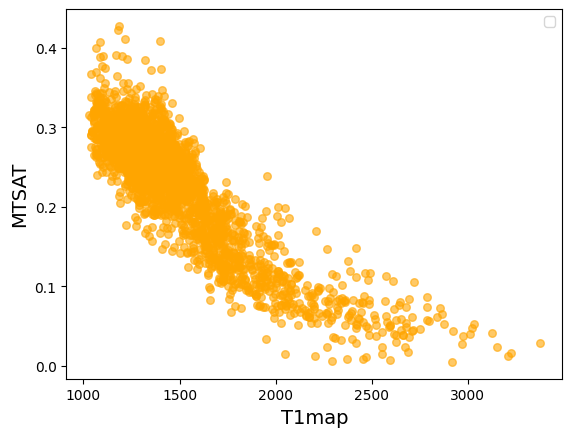

In [396]:
import matplotlib.pyplot as plt

# Scatter plot
plt.scatter(map_means_concat[:, 0], map_means_concat[:, 1], c='orange', marker='o', s=30, alpha=0.6)

#plt.title('Scatter Plot between First and Second Rows of map_means_concat')
plt.xlabel('T1map', fontsize=14)
plt.ylabel('MTSAT', fontsize=14)
plt.legend()
plt.show()

mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['xtick.labelbottom'] = True

mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.labelright'] = False
mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.labelleft'] = True

plt.show()

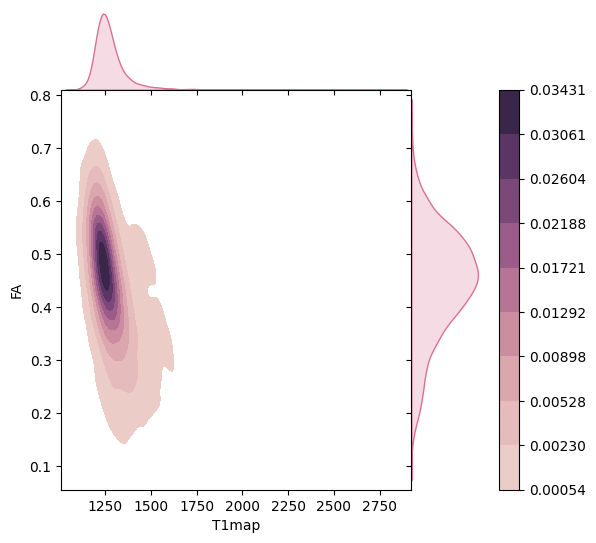

In [254]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame from the concatenated vectors
data = pd.DataFrame(data=map_means_concat, columns=qmri_list)

cmap = sns.cubehelix_palette(as_cmap=True) # T1map & MTSAT (palevioletred)
#cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
#cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)

# Plot bivariate distribution (density function)
kdeplot = sns.jointplot(x='T1map', y='FA', data=data, color='palevioletred', kind='kde', fill=True, space=0, cbar=True, cmap=cmap)

plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
# get the current positions of the joint ax and the ax for the marginal x
pos_joint_ax = kdeplot.ax_joint.get_position()
pos_marg_x_ax = kdeplot.ax_marg_x.get_position()
# reposition the joint ax so it has the same width as the marginal x ax
kdeplot.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
# reposition the colorbar using new x positions and y positions of the joint ax
kdeplot.fig.axes[-1].set_position([.83, pos_joint_ax.y0, .07, pos_joint_ax.height])

mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['xtick.labelbottom'] = True

mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.labelright'] = False
mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.labelleft'] = True

plt.show()